In [20]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import math

In [21]:
def read_efs(csv):
    return pd.read_csv(csv, engine="pyarrow")

def filter_efs(df, sector = None, state = None):
    if sector:
        if isinstance(sector, str):
            sector = [sector]
        df_temp = df[df.Sector.isin(sector)]
    else:
        df_temp = df.copy()
        
    if state:
        if isinstance(state, str):
            state = [state]
        df_filtered = df_temp[df_temp.State.isin(state)]
    else:
        df_filtered = df_temp.copy()
        
    return df_filtered

def create_datetime(row):
    start_of_year = pd.Timestamp(year=int(row["Year"]), month=1, day=1)
    delta_hours = pd.Timedelta(hours=int(row["LocalHourID"]) - 1) # -1 to start at 0
    return start_of_year + delta_hours

def resample_efs(df, resample = "d", strategy= "mean"):
    df = df.reset_index(drop=True)
    df["date"] = df.apply(create_datetime, axis=1)
    df = df.set_index("date").drop(columns=["Year","LocalHourID"])
    if strategy == "mean":
        return df.resample(resample).mean()
    else:
        return df.resample(resample).sum()

def check_duplicates(df):
    """Sometimes odd formatting for resampling"""
    
    duplicates = df[df.duplicated(subset=["time_of_year","year"])]
    
    if duplicates.empty:
        return df
    
    else:
        print(f"Dropping following duplicated data: \n {duplicates}")
        # return df.loc[duplicates.index]
        return df[~df.duplicated(subset=["time_of_year","year"], keep="last")]

def plot_efs(df, ax, resample = "d", years = None, title=None):
    if years:
        assert all(x in [2018, 2020, 2024, 2030, 2040, 2050] for x in years)
    else:
        years = [2018, 2020, 2024, 2030, 2040, 2050]
    
    temp = df[df.index.year.isin(years)].copy()
    
    if resample == "d":
        temp["time_of_year"] = temp.index.dayofyear
        x_label = "Day of Year"
    elif resample == "W":
        temp["time_of_year"] = temp.index.isocalendar().week
        x_label = "Week of Year"
    elif resample == "ME":
        temp["time_of_year"] = temp.index.month
        x_label = "Month of Year"
    elif resample == "YE":
        temp["time_of_year"] = temp.index.year
        x_label = "Year"
    else:
        temp["time_of_year"] = temp.index.hour
        x_label = "Hour of Year"
    temp["year"] = temp.index.year
    
    # print(temp)
    
    temp = check_duplicates(temp)
    
    if resample != "YE":
        
        temp = temp.pivot(
            index="time_of_year", 
            columns="year", 
            values="LoadMW"
        )
        
        temp.plot(ax=ax)
        
    else:
        
        temp.plot.bar(ax=ax, x="time_of_year", y="LoadMW")
        
    ax.set_xlabel(x_label)
    ax.set_ylabel("Load (MW)")
    
    if title:
        ax.set_title(title)
    
def filter_and_plot(df, plot_by_subsector = False, **kwargs):
    """Main function to interface with"""
    
    sector = kwargs.get("sector", None)
    state = kwargs.get("state", None)
    resample = kwargs.get("resample", "d")
    years = kwargs.get("years", [2018, 2020, 2024, 2030, 2040, 2050])
    title = kwargs.get("title", None)
    figsize = kwargs.get("figsize", (18,8))
    
    # note, hourly resample will have no effect 
    assert resample in ["h" ,"d", "W", "ME", "YE"]
    
    df = filter_efs(df, sector=sector, state=state)

    if plot_by_subsector:
        nsubsectors = len(df.Subsector.unique())
        fig, axs = plt.subplots(
            nrows=math.ceil(nsubsectors/2), 
            ncols=2, 
            figsize=figsize
        )
        
        row, col = 0, 0
        for i, subsector in enumerate(df.Subsector.unique()):
            temp = df[df.Subsector == subsector]
            temp = temp[["Year","LocalHourID","LoadMW"]]
            resampled = resample_efs(temp, resample=resample)
            plot_efs(resampled, axs[row, col], resample, years, subsector)
            row = row if col % 2 == 0 else row + 1
            col = 0 if col % 2 == 1 else col + 1

    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize) 
        resampled = resample_efs(df[["Year","LocalHourID","LoadMW"]], resample=resample)
        plot_efs(resampled, ax, resample, years)
        
    if title:
        fig.suptitle(title, fontsize=24)

# High Rapid

In [22]:
csv = "EFSLoadProfile_High_Rapid.csv"
df = read_efs(csv)

In [23]:
FIGSIZE = (18, 10)

## California

Dropping following duplicated data: 
                 LoadMW  time_of_year  year
date                                      
2040-12-30  928.353903            52  2040
Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  5436.750623            52  2040
Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  3344.959083            52  2040
Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  1099.456583            52  2040


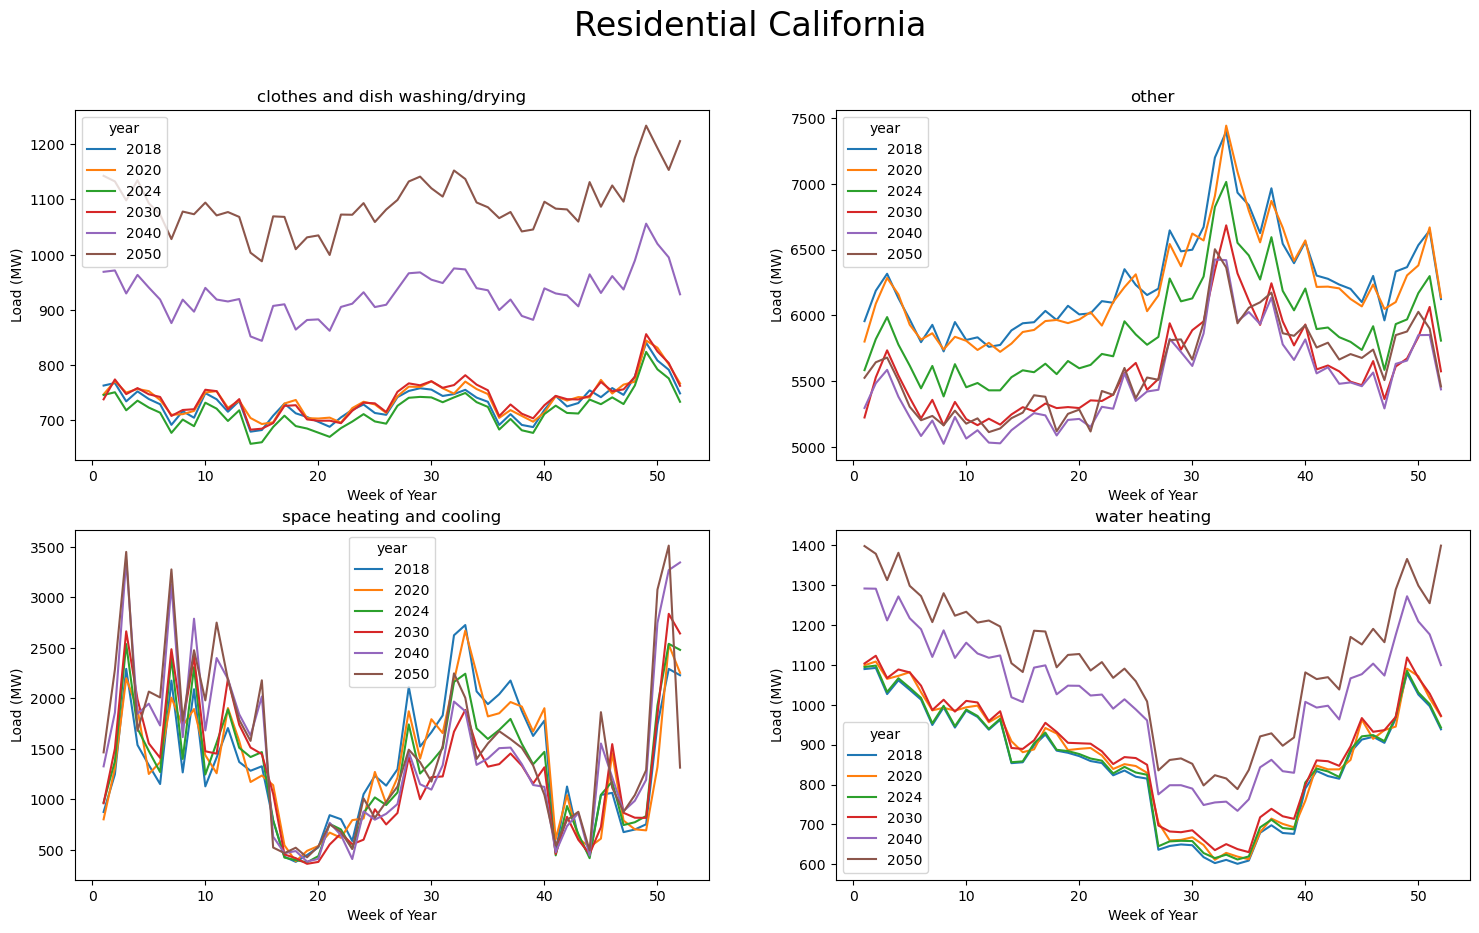

In [24]:
filter_and_plot(df, sector="Residential", state="CA", resample="W", figsize=FIGSIZE, plot_by_subsector=True, title="Residential California")

Dropping following duplicated data: 
                   LoadMW  time_of_year  year
date                                        
2040-12-30  12650.084263            52  2040
Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  1308.971264            52  2040
Dropping following duplicated data: 
                 LoadMW  time_of_year  year
date                                      
2040-12-30  191.979401            52  2040


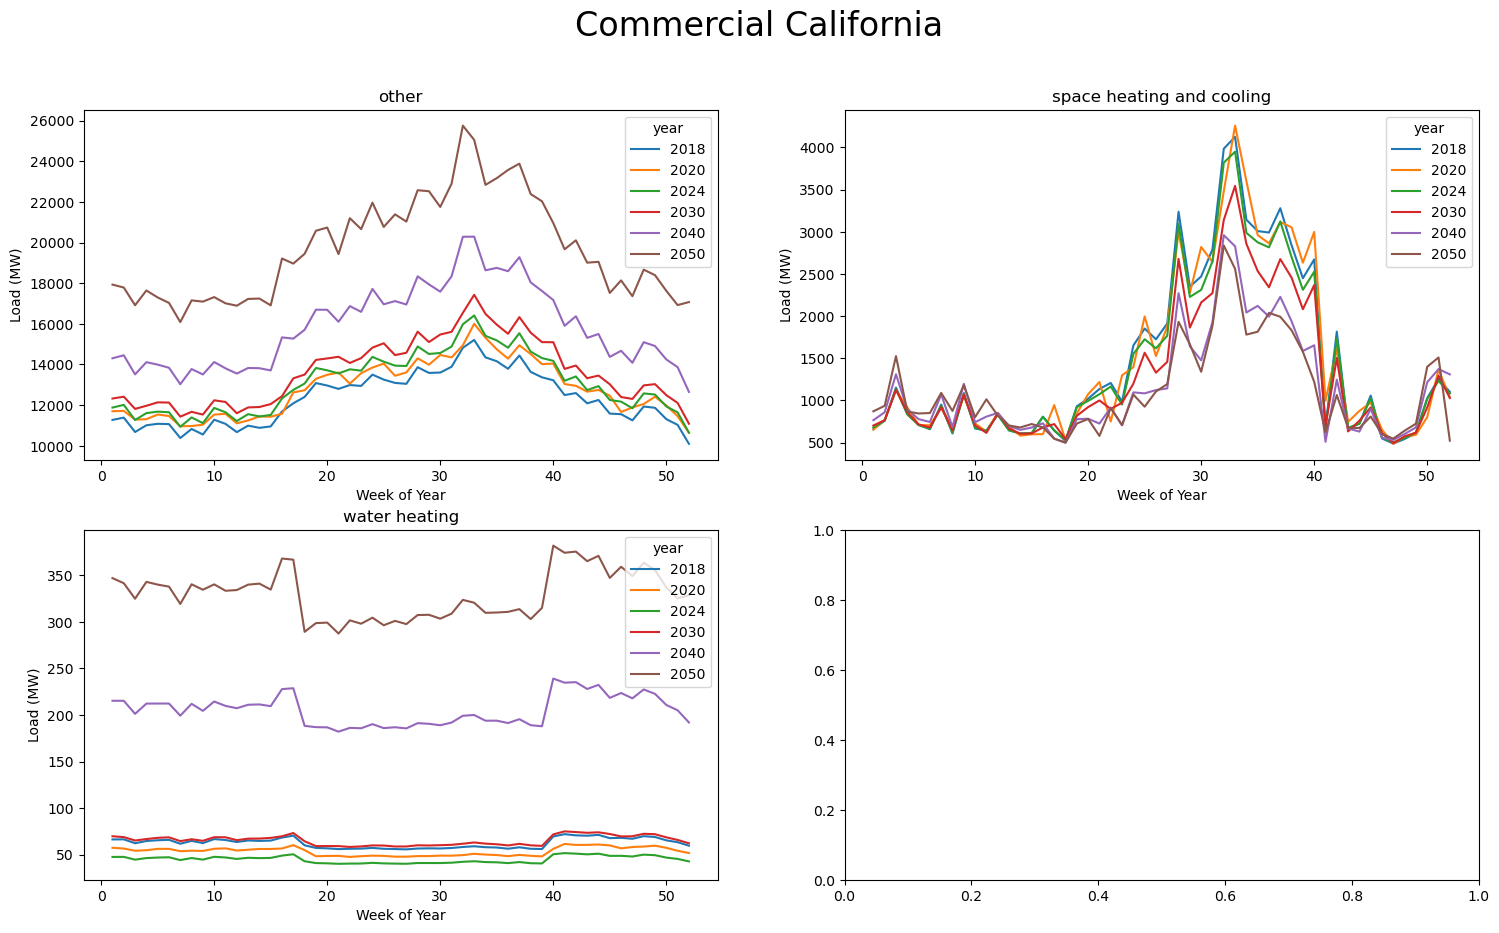

In [25]:
filter_and_plot(df, sector="Commercial", state="CA", resample="W", figsize=FIGSIZE, plot_by_subsector=True, title="Commercial California")

Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  2831.462738            52  2040
Dropping following duplicated data: 
                 LoadMW  time_of_year  year
date                                      
2040-12-30  4490.68987            52  2040
Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  1552.525262            52  2040


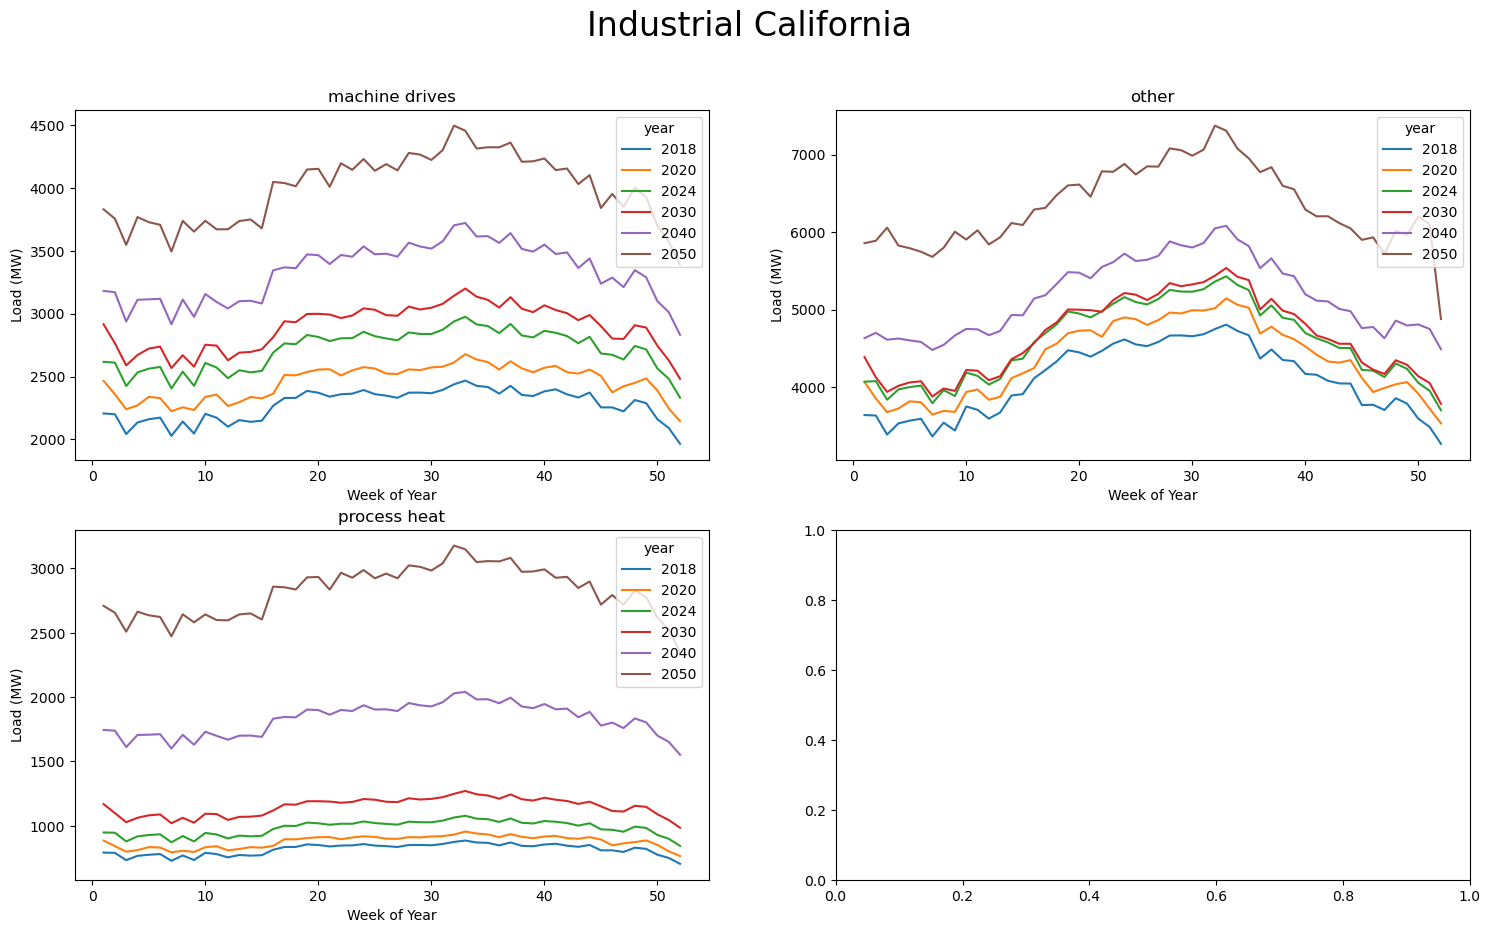

In [26]:
filter_and_plot(df, sector="Industrial", state="CA", resample="W", figsize=FIGSIZE, plot_by_subsector=True, title="Industrial California")

Dropping following duplicated data: 
                 LoadMW  time_of_year  year
date                                      
2040-12-30  1097.77994            52  2040
Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  5834.676667            52  2040
Dropping following duplicated data: 
                 LoadMW  time_of_year  year
date                                      
2040-12-30  986.563923            52  2040
Dropping following duplicated data: 
                LoadMW  time_of_year  year
date                                     
2040-12-30  91.411479            52  2040


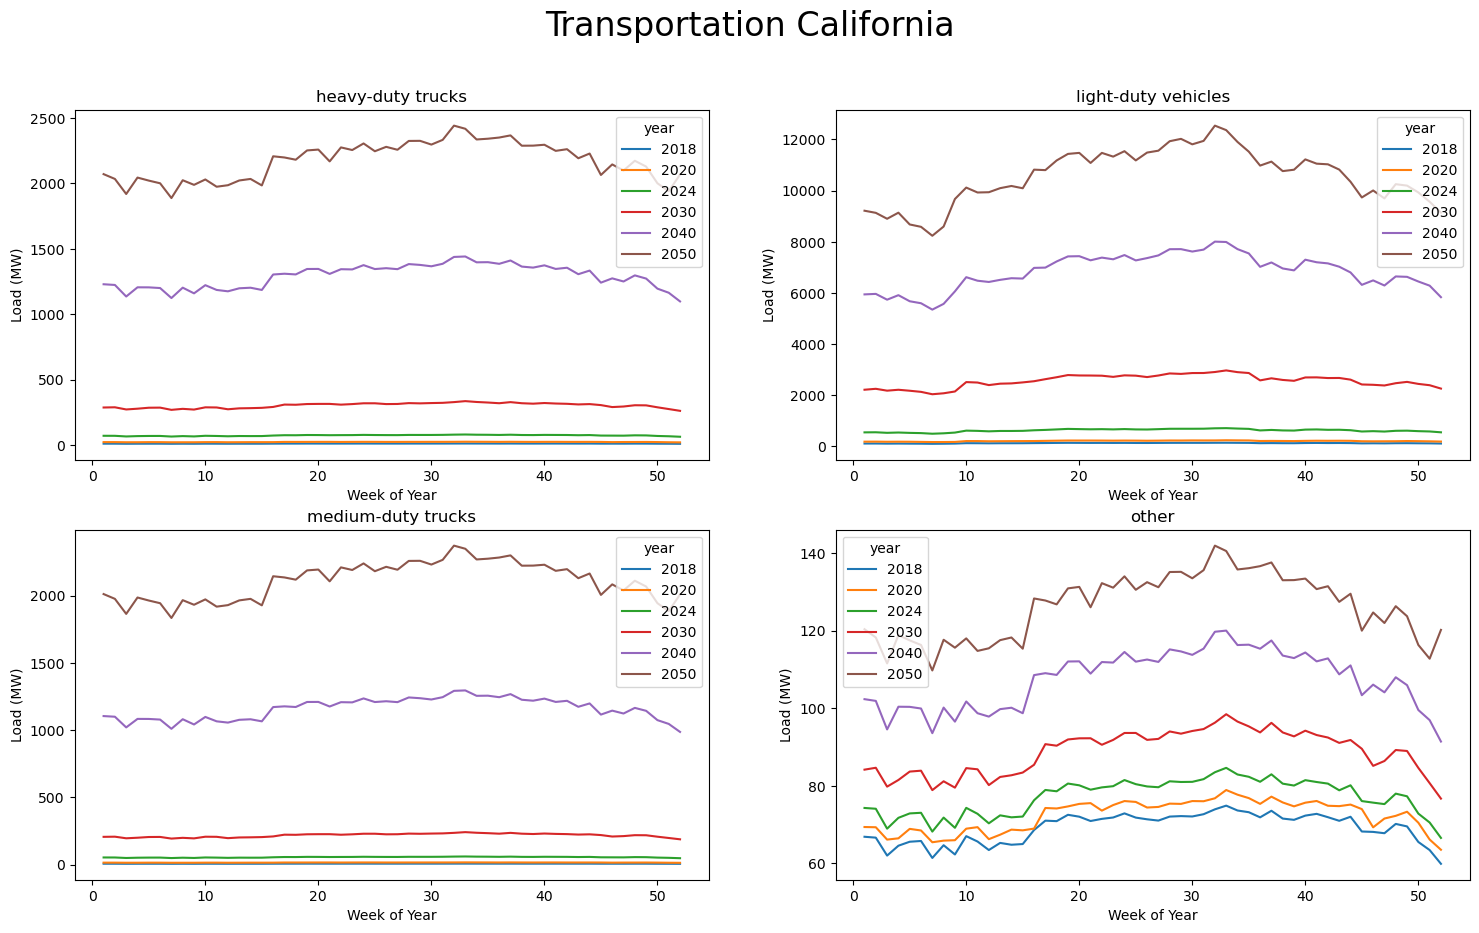

In [27]:
filter_and_plot(df, sector="Transportation", state="CA", resample="W", figsize=FIGSIZE, plot_by_subsector=True, title="Transportation California")

## Texas

Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  1062.334459            52  2040
Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  12751.47304            52  2040
Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  8742.368346            52  2040
Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  1496.514906            52  2040


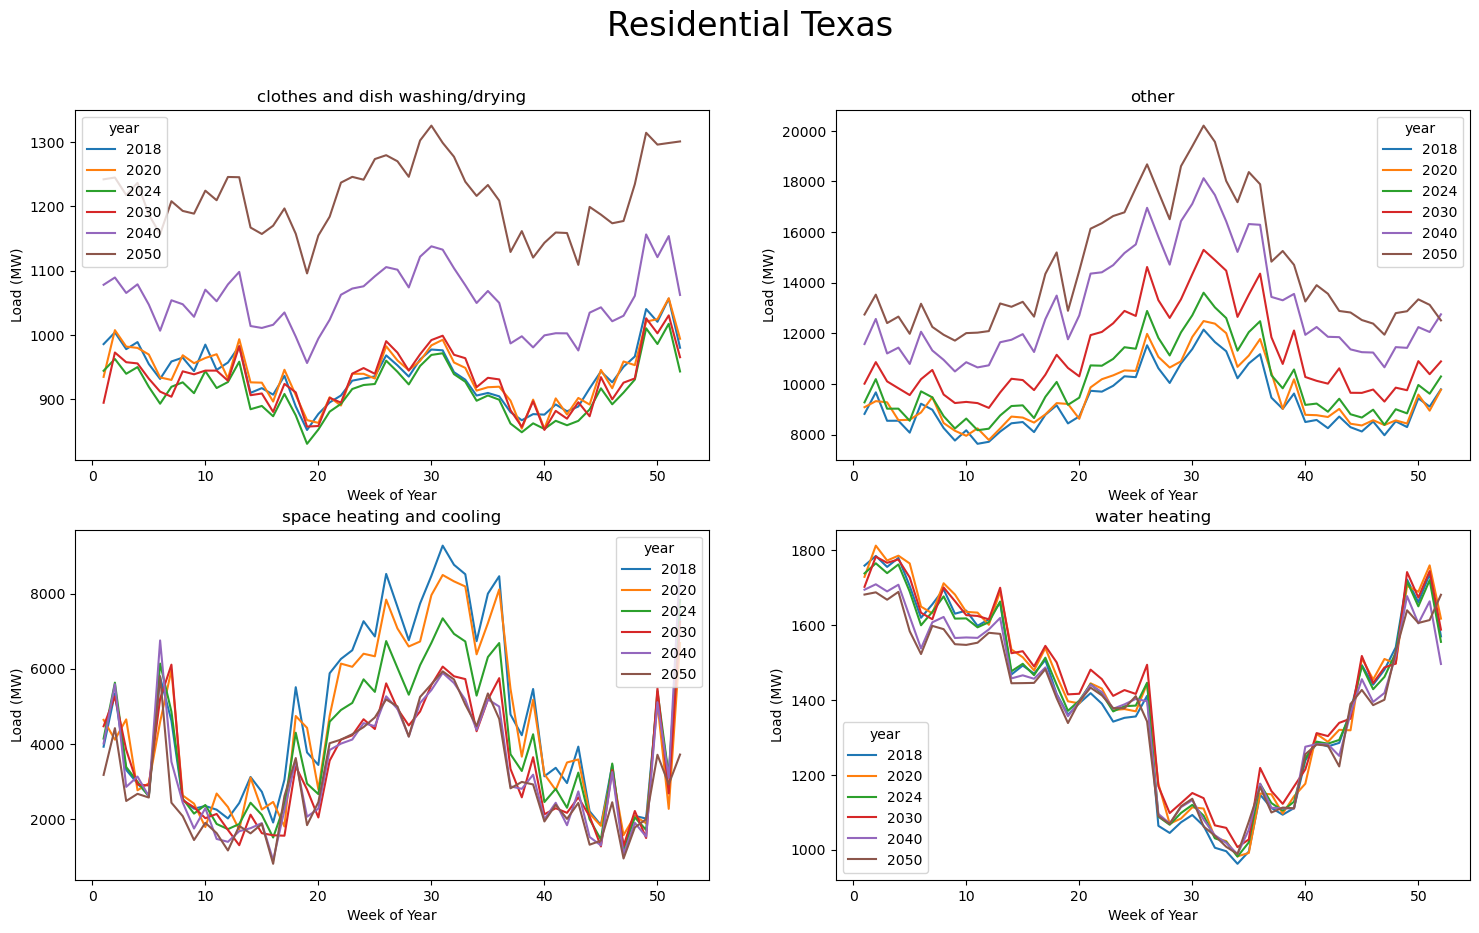

In [28]:
filter_and_plot(df, sector="Residential", state="TX", resample="W", figsize=FIGSIZE, plot_by_subsector=True, title="Residential Texas")

Dropping following duplicated data: 
                   LoadMW  time_of_year  year
date                                        
2040-12-30  12557.582927            52  2040
Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  2868.319395            52  2040
Dropping following duplicated data: 
                 LoadMW  time_of_year  year
date                                      
2040-12-30  193.146347            52  2040


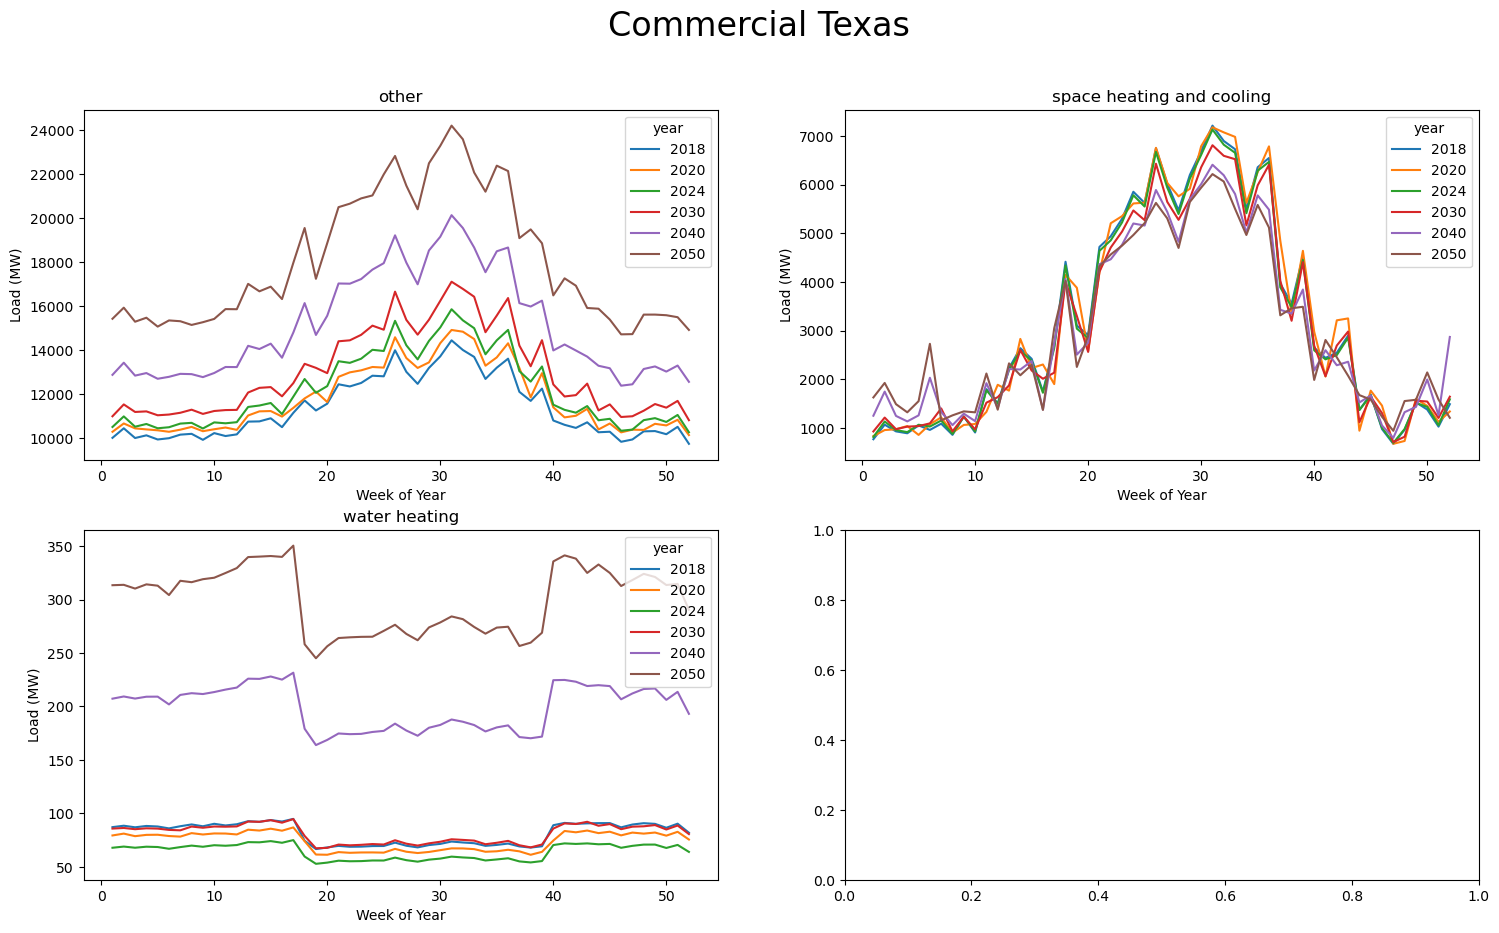

In [29]:
filter_and_plot(df, sector="Commercial", state="TX", resample="W", figsize=FIGSIZE, plot_by_subsector=True, title="Commercial Texas")

Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  5853.594857            52  2040
Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  8554.453008            52  2040
Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  2415.175868            52  2040


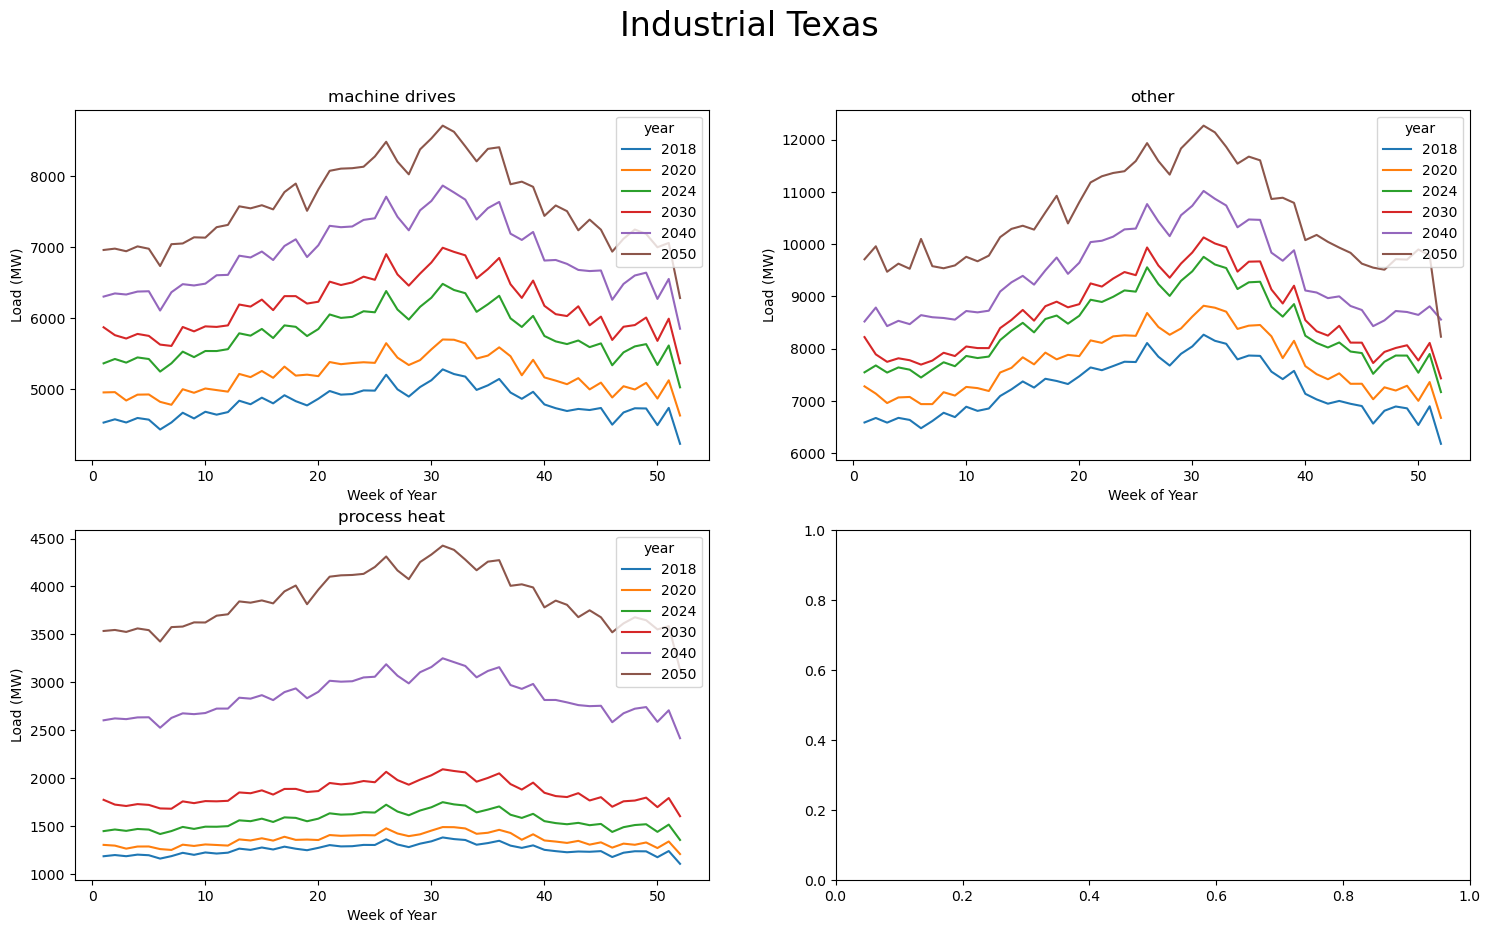

In [30]:
filter_and_plot(df, sector="Industrial", state="TX", resample="W", figsize=FIGSIZE, plot_by_subsector=True, title="Industrial Texas")

Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  1922.755426            52  2040
Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  5262.059215            52  2040
Dropping following duplicated data: 
                  LoadMW  time_of_year  year
date                                       
2040-12-30  1152.008065            52  2040
Dropping following duplicated data: 
                LoadMW  time_of_year  year
date                                     
2040-12-30  94.379235            52  2040


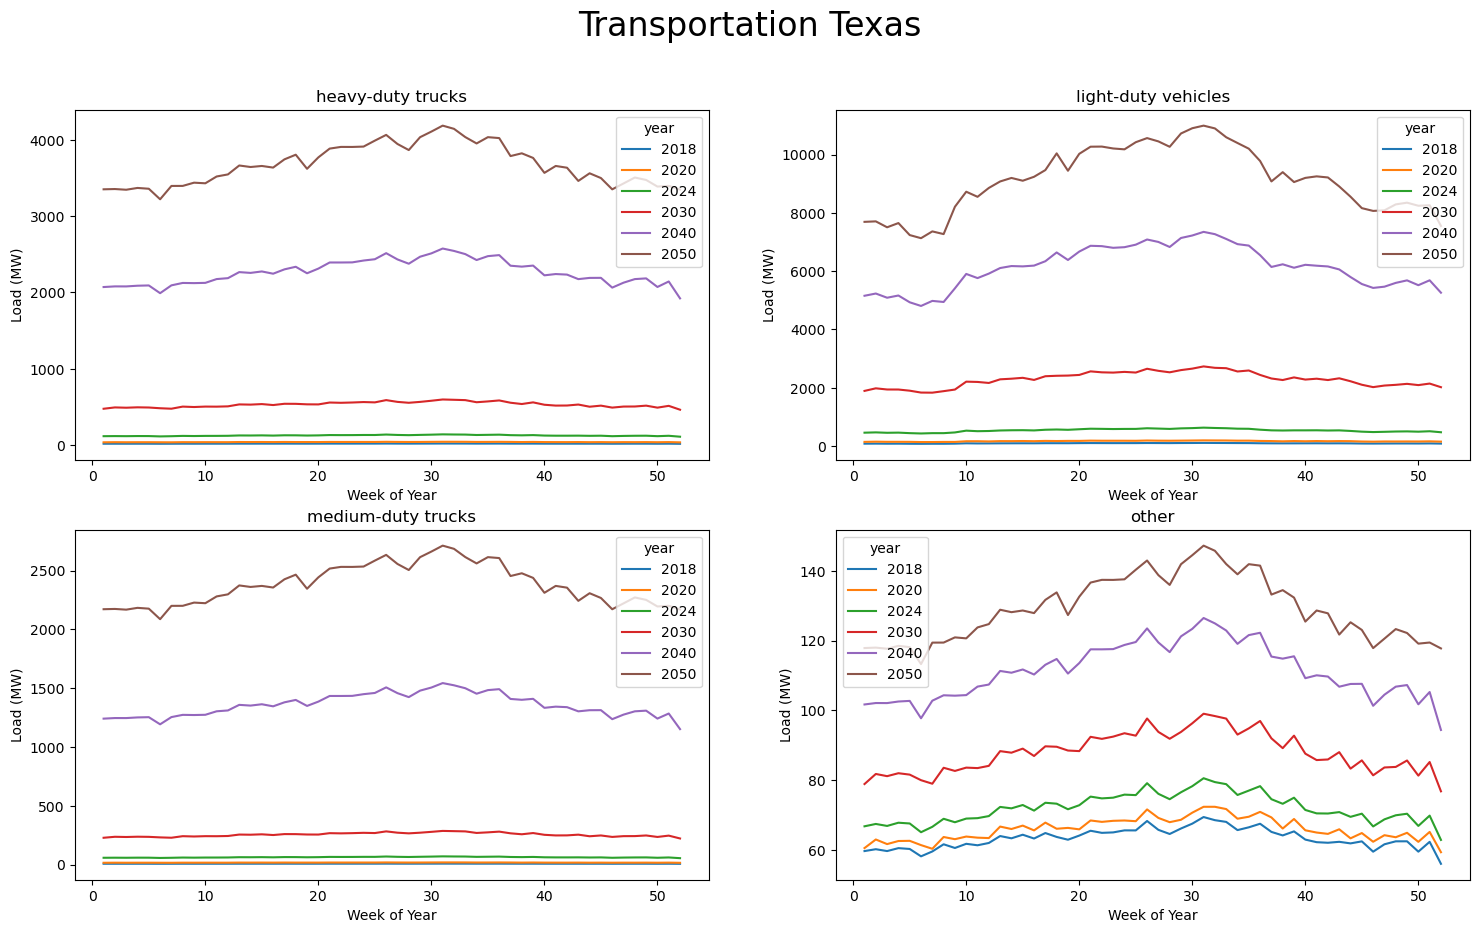

In [31]:
filter_and_plot(df, sector="Transportation", state="TX", resample="W", figsize=FIGSIZE, plot_by_subsector=True, title="Transportation Texas")

## New England

Dropping following duplicated data: 
                LoadMW  time_of_year  year
date                                     
2040-12-30  71.532209            52  2040
Dropping following duplicated data: 
               LoadMW  time_of_year  year
date                                    
2040-12-30  507.5581            52  2040
Dropping following duplicated data: 
                 LoadMW  time_of_year  year
date                                      
2040-12-30  467.074948            52  2040
Dropping following duplicated data: 
                LoadMW  time_of_year  year
date                                     
2040-12-30  87.914912            52  2040


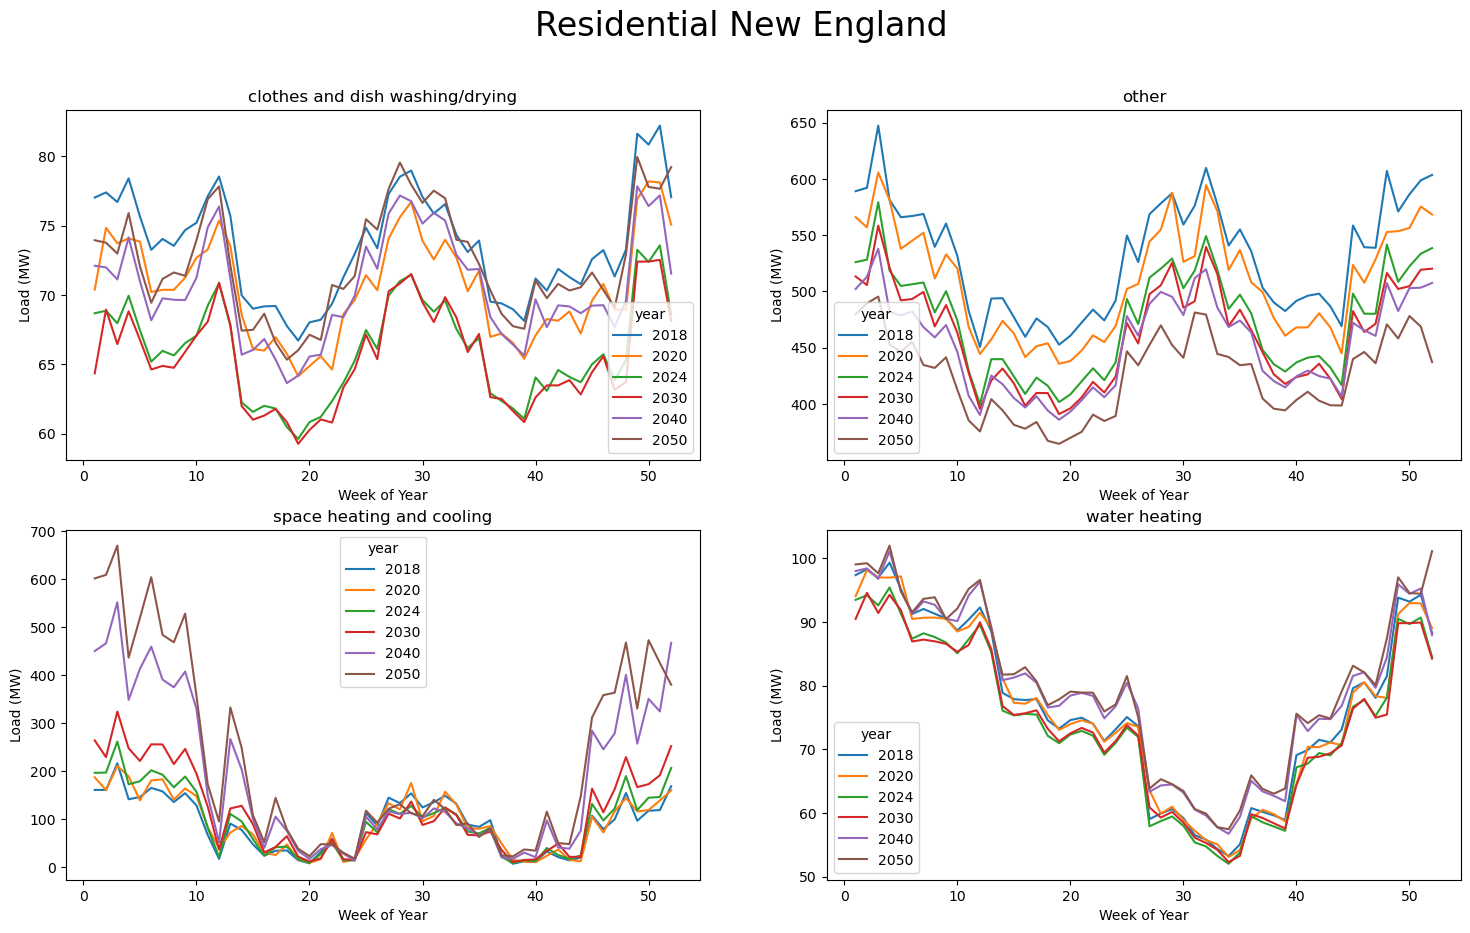

In [32]:
filter_and_plot(df, sector="Residential", state=["CT", "ME", "MA", "NH", "RI", "VT"], resample="W", figsize=FIGSIZE, plot_by_subsector=True, title="Residential New England")

Dropping following duplicated data: 
                 LoadMW  time_of_year  year
date                                      
2040-12-30  880.242416            52  2040
Dropping following duplicated data: 
                LoadMW  time_of_year  year
date                                     
2040-12-30  304.01437            52  2040
Dropping following duplicated data: 
               LoadMW  time_of_year  year
date                                    
2040-12-30  3.056936            52  2040


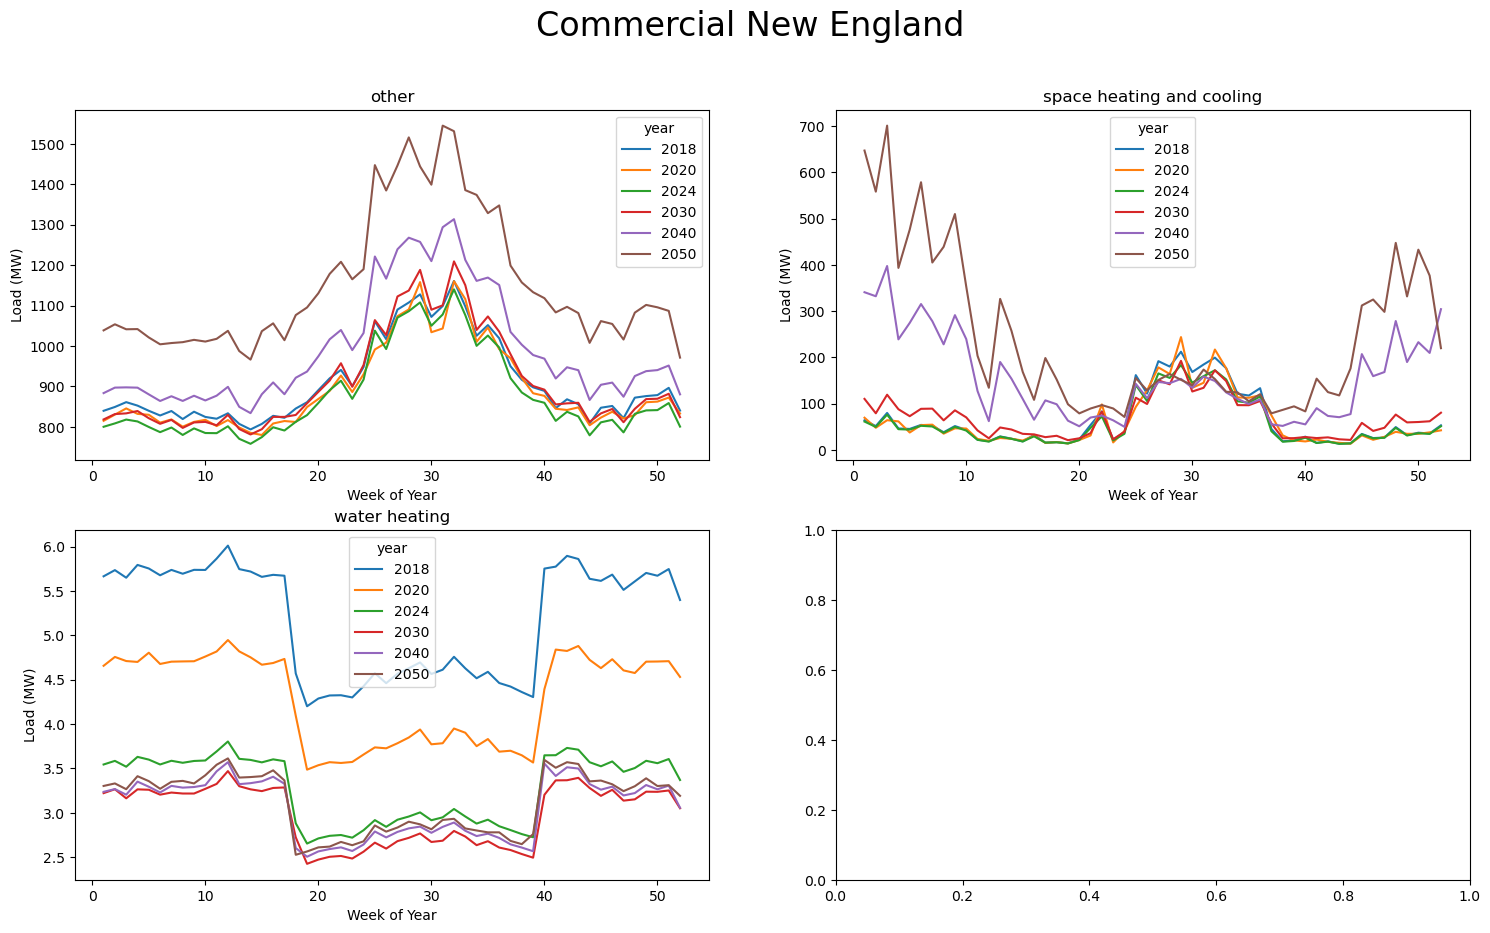

In [33]:
filter_and_plot(df, sector="Commercial", state=["CT", "ME", "MA", "NH", "RI", "VT"], resample="W", figsize=FIGSIZE, plot_by_subsector=True, title="Commercial New England")

Dropping following duplicated data: 
                 LoadMW  time_of_year  year
date                                      
2040-12-30  142.032848            52  2040
Dropping following duplicated data: 
                 LoadMW  time_of_year  year
date                                      
2040-12-30  270.540061            52  2040
Dropping following duplicated data: 
                LoadMW  time_of_year  year
date                                     
2040-12-30  15.894673            52  2040


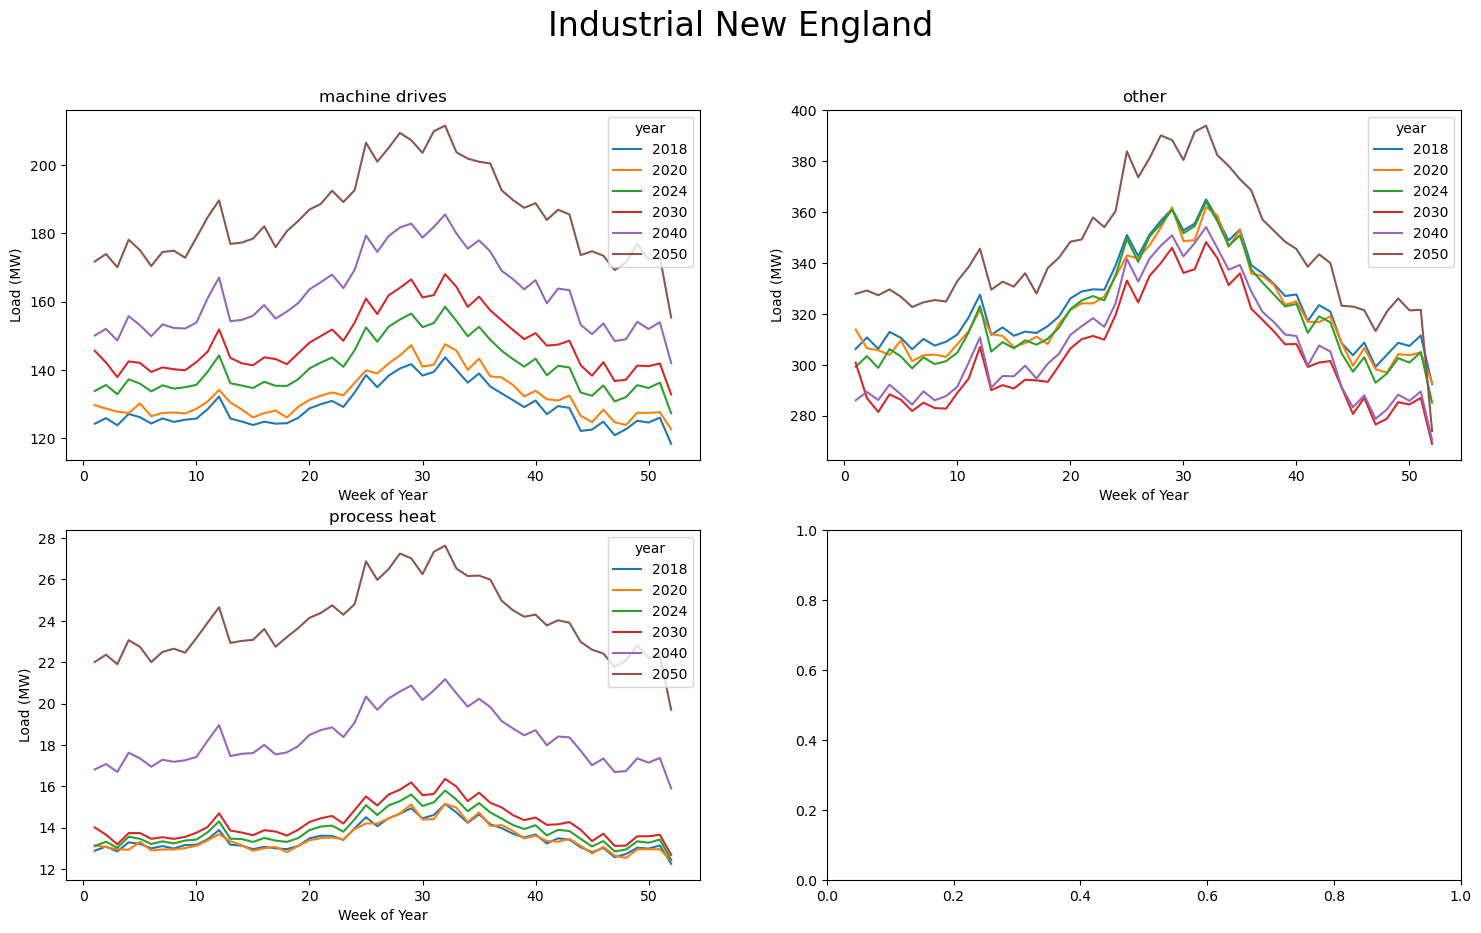

In [34]:
filter_and_plot(df, sector="Industrial", state=["CT", "ME", "MA", "NH", "RI", "VT"], resample="W", figsize=FIGSIZE, plot_by_subsector=True, title="Industrial New England")

Dropping following duplicated data: 
                LoadMW  time_of_year  year
date                                     
2040-12-30  29.286524            52  2040
Dropping following duplicated data: 
                 LoadMW  time_of_year  year
date                                      
2040-12-30  405.931056            52  2040
Dropping following duplicated data: 
                LoadMW  time_of_year  year
date                                     
2040-12-30  49.928744            52  2040
Dropping following duplicated data: 
               LoadMW  time_of_year  year
date                                    
2040-12-30  7.284092            52  2040


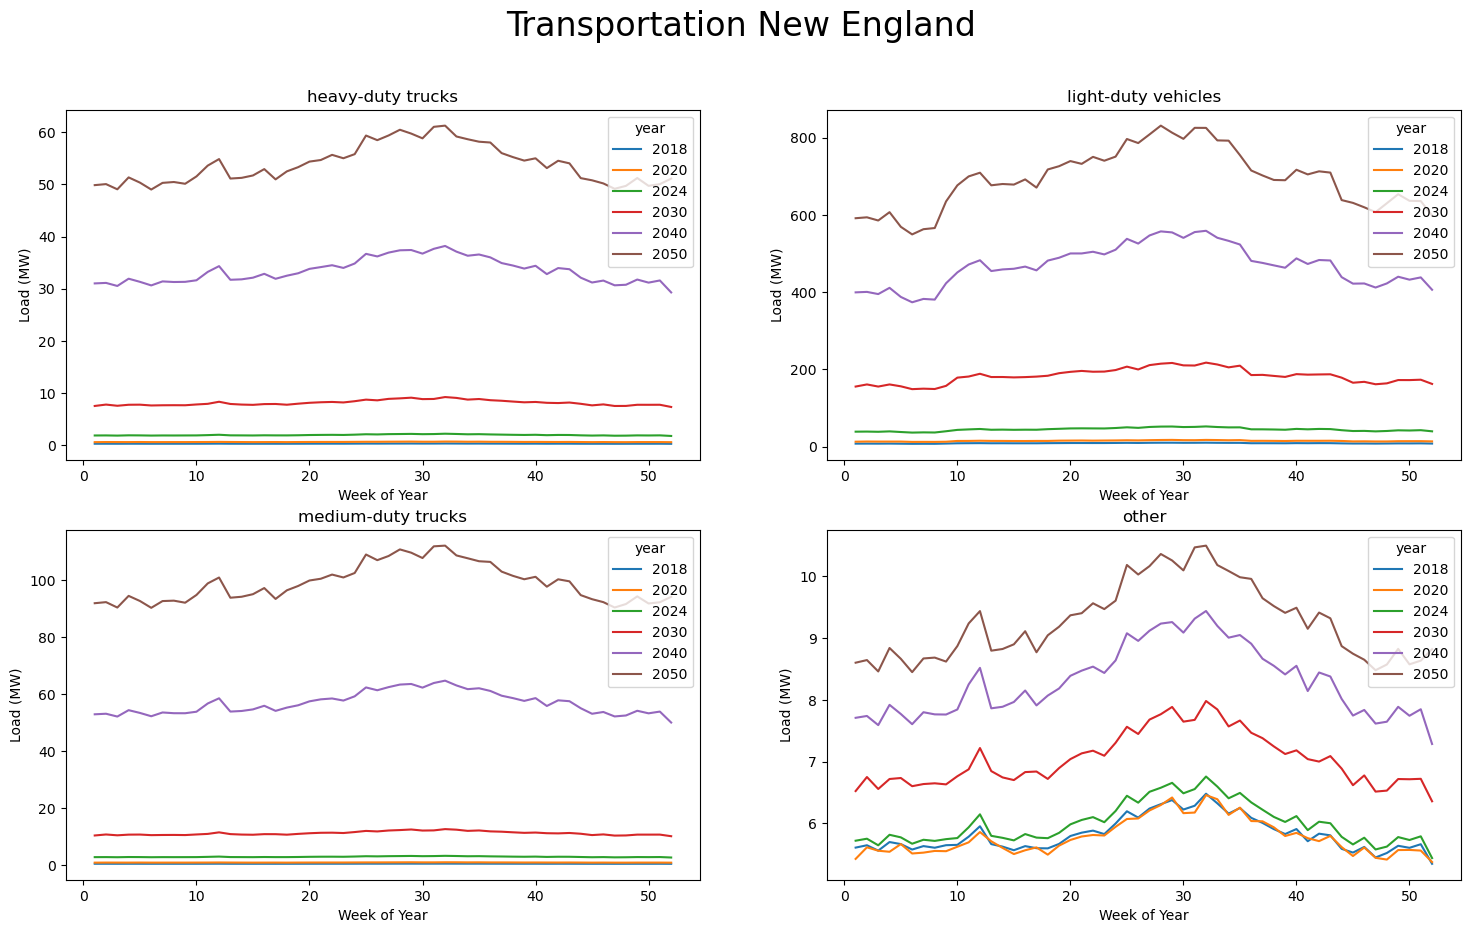

In [35]:
filter_and_plot(df, sector="Transportation", state=["CT", "ME", "MA", "NH", "RI", "VT"], resample="W", figsize=FIGSIZE, plot_by_subsector=True, title="Transportation New England")